# 2025.2.18 NKTCL_02_CNV

In [185]:
import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams['font.family'] = 'Arial'
figPath = "NKTCL-figure-2.18"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

Load RNA and IR h5ad data

In [188]:
nktcl_ir = sc.read_h5ad("/data/NKTCL/NKTCL_Multi/analysis/NKTCL-ir-EBV.h5ad")
adata_concat = sc.read_h5ad("/data/NKTCL/NKTCL_Multi/analysis/NKTCL-gex-EBV-3.7.h5ad")

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Import cnv related libraries and chrom index

In [189]:
import infercnvpy as cnv 
import pandas as pd
chrom = pd.read_csv("gene_pos.txt", sep='\t', header=None)
chrom.columns = ["symbol", "ensg", "chromosome", "start", "end"]
chrom['ensg'] = [name.split('.')[0] for name in chrom['ensg']]
chrom.index = chrom['ensg']
chrom_ensg = chrom.copy()
chrom_ensg.index = chrom_ensg['ensg']
var_names = list(adata_concat.var['ID'][adata_concat.var['ID'].isin(chrom['ensg'])])
chrom_var_names = chrom.loc[var_names, :]
for i in range(len(var_names)):
    name = var_names[i]
    if name in chrom_ensg['ensg']:
        var_names[i] = chrom_ensg['symbol'][name]
chrom_var_names.index = var_names

Concat chrom index to gex file

In [190]:
adata_concat_cnv = adata_concat[:, adata_concat.var['ID'].isin(chrom['ensg'])]
adata_concat_cnv.var_names = var_names
adata_concat_cnv.var = pd.concat([adata_concat_cnv.var, chrom_var_names], axis=1)
adata_concat_cnv.var_names_make_unique()
adata_concat_cnv

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 170213 × 31852
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden-1', 'leiden-pca', 'anno-pca', 'treatment'
    var: 'ID', 'name', 'type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'anno-pca_colors', 'batch_colors', 'dendrogram_anno-pca', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-pca_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'Raw'
    obsp: 'connectivities', 'distances'

Perform InferCNV for immune cells with Endothelial as reference

In [191]:
adata_concat_cnv = adata_concat_cnv[adata_concat_cnv.obs['anno-pca'].isin(
  ['T cells', 'NK cells', 'Immune mixed', 'Myeloid cells', 'Endothelial', 'Stromal cells'])]

In [192]:
adata_concat_cnv.obs['anno-pca'].unique()

['Myeloid cells', 'Immune mixed', 'T cells', 'NK cells', 'Endothelial', 'Stromal cells']
Categories (6, object): ['Endothelial', 'Immune mixed', 'Myeloid cells', 'NK cells', 'Stromal cells', 'T cells']

In [193]:
cnv.tl.infercnv(adata_concat_cnv,reference_key="anno-pca", reference_cat=['Endothelial', 'Stromal cells'])

  0%|          | 0/28 [00:00<?, ?it/s]

/home/rzh/BCY/lib/python3.10/site-packages/infercnvpy/tl/_infercnv.py:131: ImplicitModificationWarning: Setting element `.obsm['X_cnv']` of view, initializing view as actual.
  adata.obsm[f"X_{key_added}"] = res


Perfrom cnv_umap for immune cells

In [198]:
adata_concat_cnv = adata_concat_cnv[adata_concat_cnv.obs['anno-pca'].isin(
  ['T cells', 'NK cells', 'Immune mixed'])]
cnv.tl.pca(adata_concat_cnv) 
cnv.pp.neighbors(adata_concat_cnv) 
cnv.tl.leiden(adata_concat_cnv)
cnv.tl.umap(adata_concat_cnv) 
cnv.tl.cnv_score(adata_concat_cnv)

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/rzh/BCY/lib/python3.10/site-packages/infercnvpy/tl/__init__.py:73: ImplicitModificationWarning: Setting element `.obsm['X_cnv_pca']` of view, initializing view as actual.
  adata.obsm[f"X_{key_added}"] = pca_res


In [227]:
adata_concat.obs['LMP-1'] = adata_concat[:, 'LMP-1'].X.toarray().flatten()

In [228]:
adata_concat_cnv.obs['LMP-1'] = adata_concat.obs['LMP-1']

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


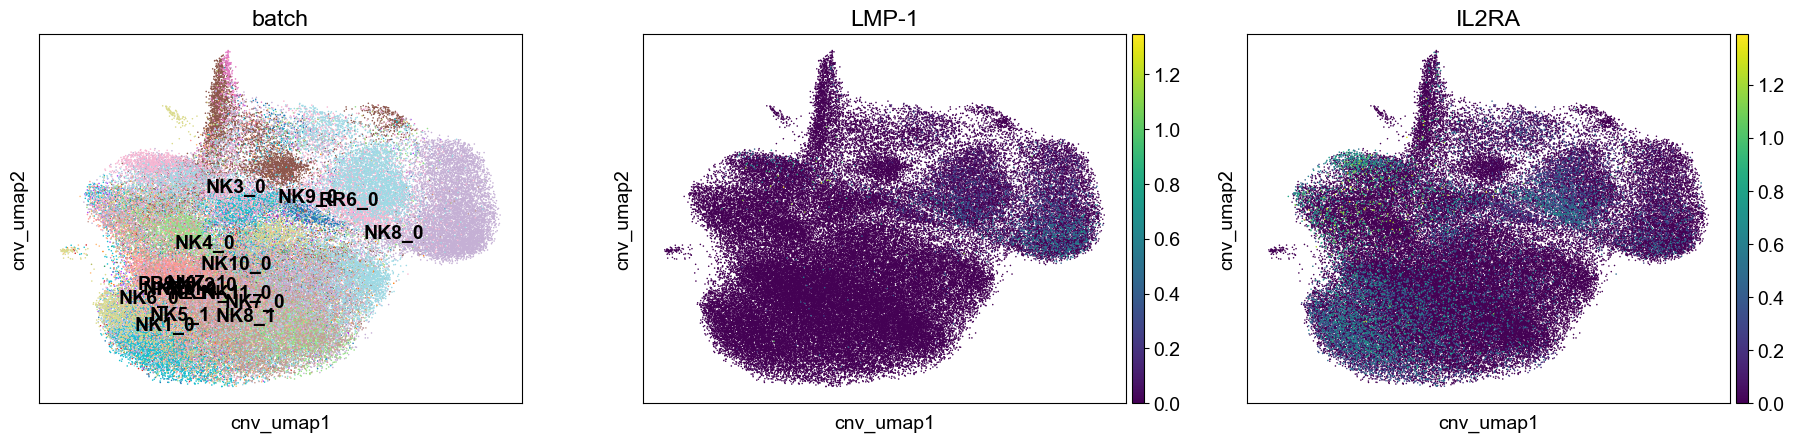

In [233]:
cnv.pl.umap(adata_concat_cnv, color=['batch', 'LMP-1', 'IL2RA'], legend_loc='on data', size=5)

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


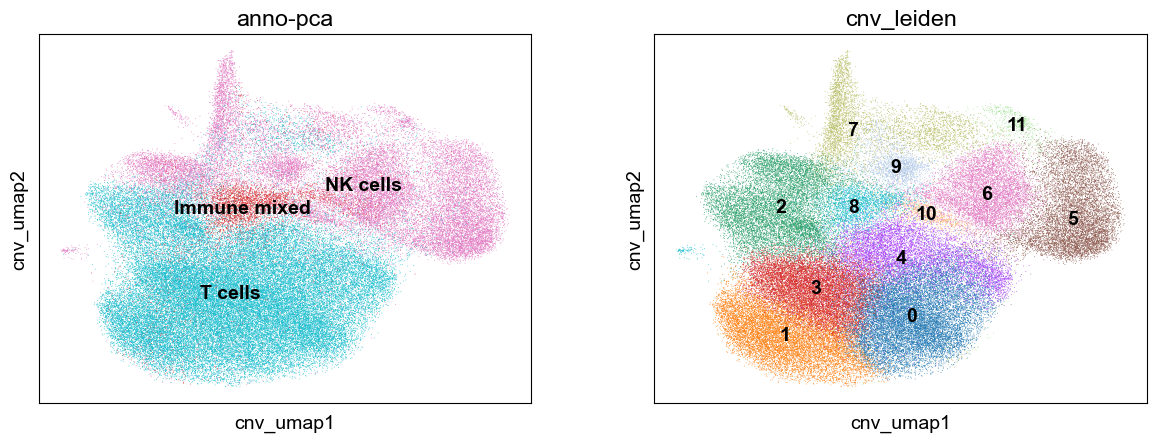

In [234]:
cnv.pl.umap(adata_concat_cnv, color=['anno-pca', 'cnv_leiden'], legend_loc='on data')

In [196]:
def anno(adata:ad.AnnData, annoDict:dict, obsKey='cnv_status', obsVal='cnv_leiden', default="Unknown"):
  if default is not None:
    adata.obs[obsKey] = default
  for key in annoDict.keys():
    adata.obs.loc[adata.obs[obsVal].isin(annoDict[key]), obsKey] = key
  return adata

... storing 'cnv_status' as categorical
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


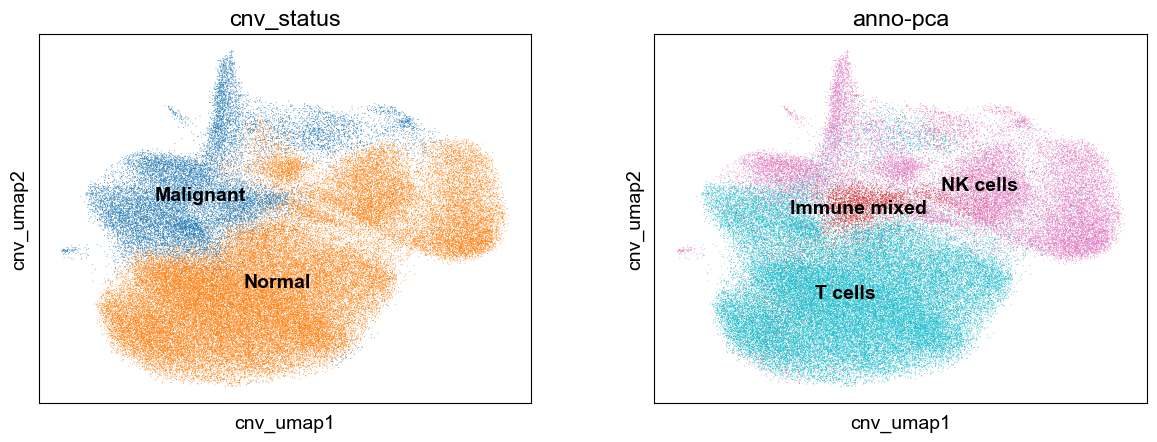

In [201]:
annot = {
  'Malignant': ['2','7', '8', '11'],
}
adata_concat_cnv = anno(adata_concat_cnv, annot, 'cnv_status','cnv_leiden','Normal')
cnv.pl.umap(adata_concat_cnv, color=['cnv_status', 'anno-pca'], legend_loc='on data')

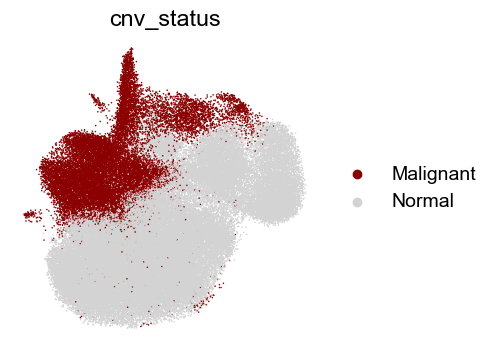

In [ ]:
for gene in ['cnv_status']: # 'cnv_score', 'ENTPD1'
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  cnv.pl.umap(adata_concat_cnv, color=gene, ax=ax, show=False, size=5, palette=['darkred', 'lightgray'])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.set_xlabel("")
  ax.set_ylabel("")
  # ax.legend(  handletextpad=0.5, frameon=False,
  #                     borderpad=0.6,
  #                     columnspacing=1.3,
  #                     handlelength=0.65, fontsize=12)
  fig.savefig(f"{figPath}/EBV-{gene}.png", dpi=400, bbox_inches='tight')

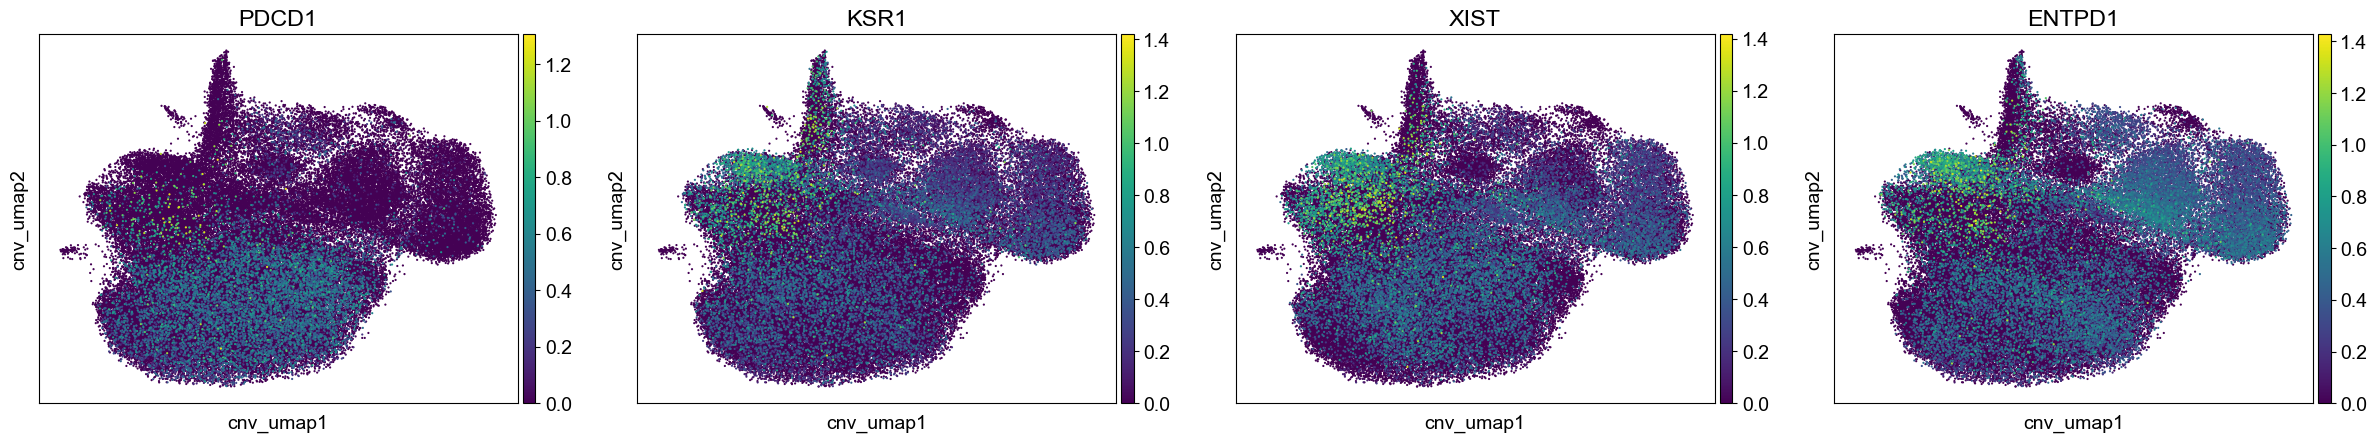

In [ ]:
cnv.pl.umap(adata_concat_cnv, color=['PDCD1', 'KSR1', 'XIST', 'ENTPD1'], size=10)

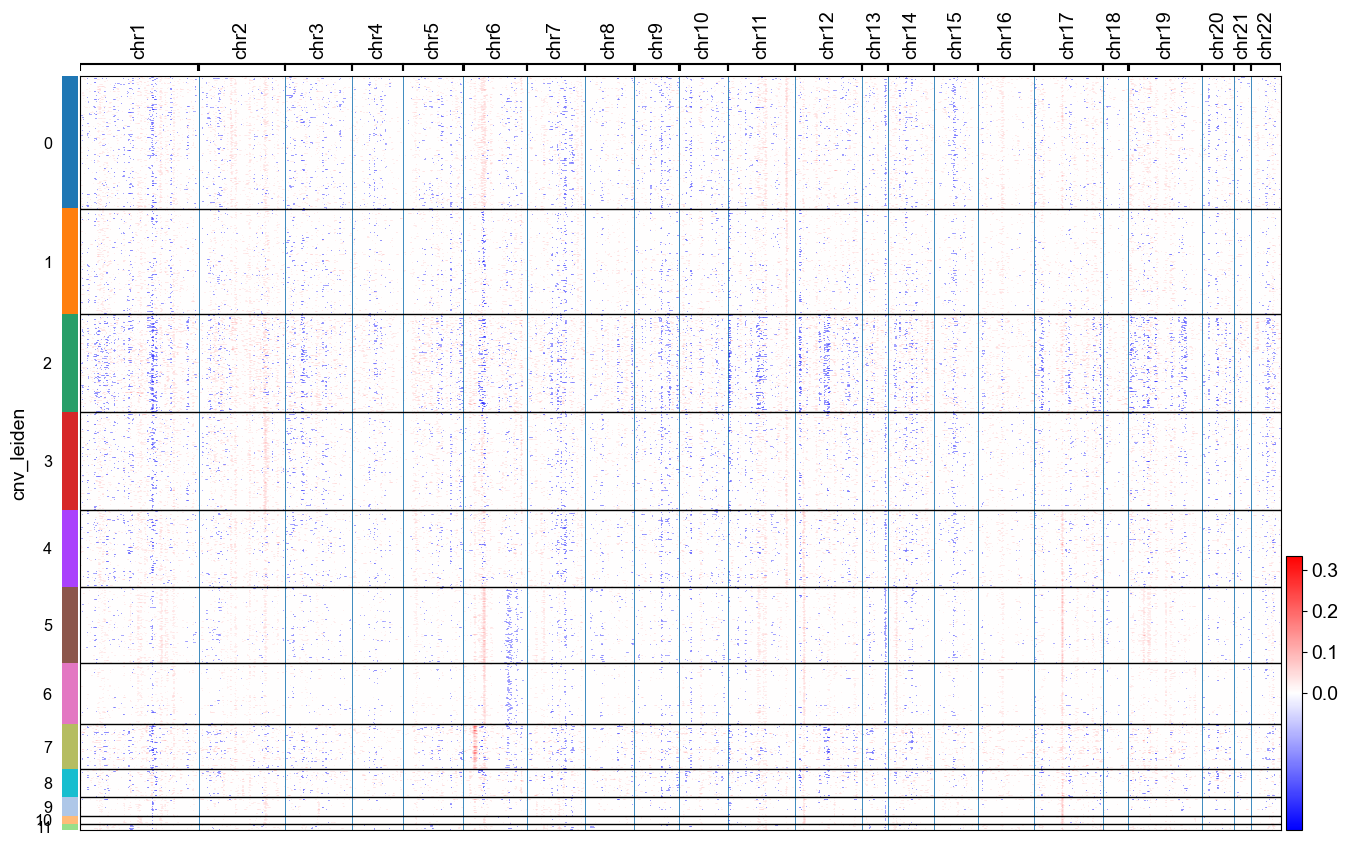

In [219]:
cnv.pl.chromosome_heatmap(adata_concat_cnv, groupby='cnv_leiden', save='EBV-leiden-cnvHeatmap.svg')

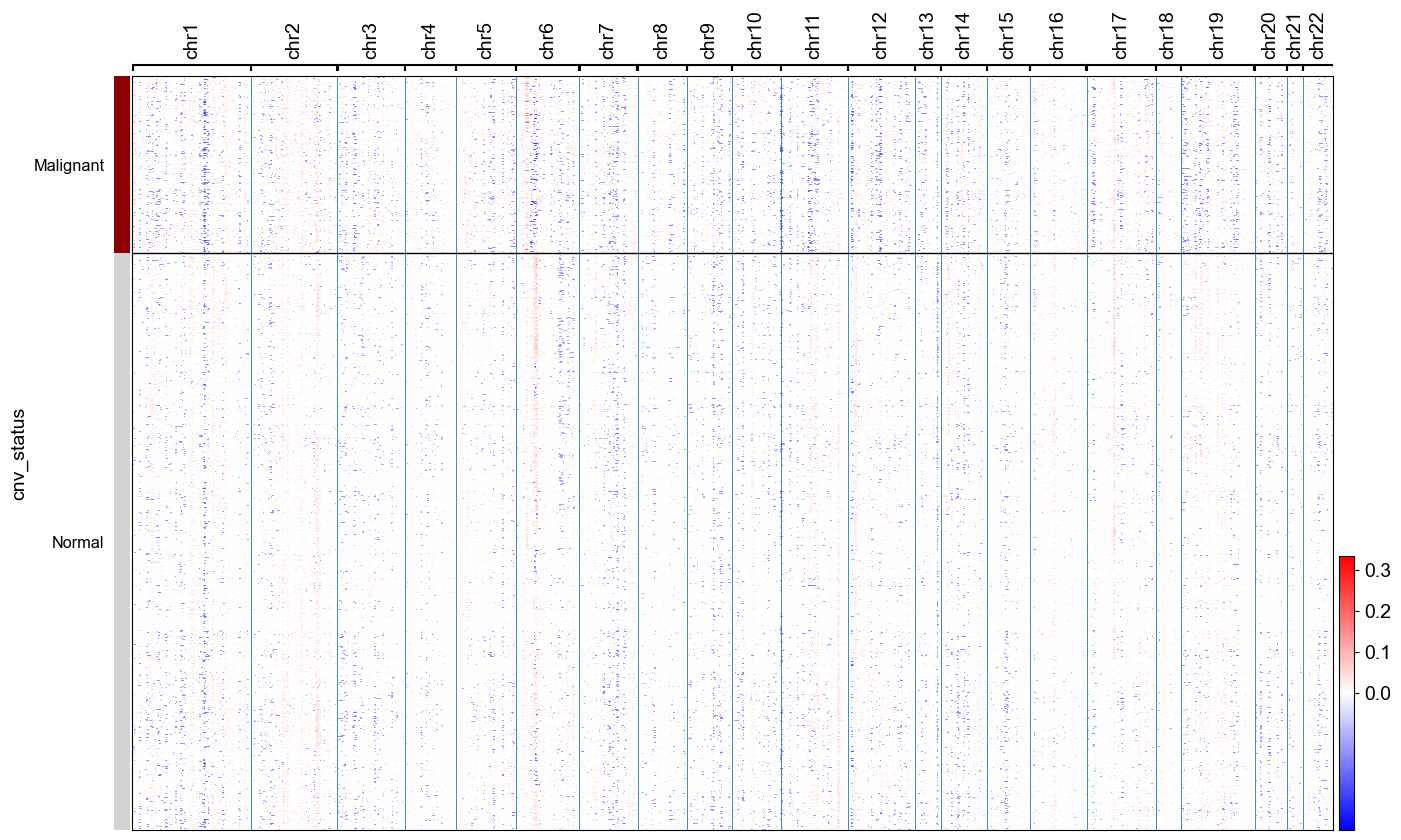

In [296]:
cnv.pl.chromosome_heatmap(adata_concat_cnv, groupby='cnv_status', save='EBV-status-cnvHeatmap.svg')

Map CNV results to major gex file

In [206]:
adata_concat.obs['cnv_status'] = adata_concat_cnv.obs['cnv_status']
adata_concat.obs['cnv_score'] = adata_concat_cnv.obs['cnv_score']
adata_concat.obs.loc[adata_concat.obs['anno-pca'].isin(['Mast cells','Epithelial', 'B cells', 'Plasma cells', 'Endothelial', 'Stromal cells', 'Myeloid cells']), 'cnv_status'] = 'Normal'

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


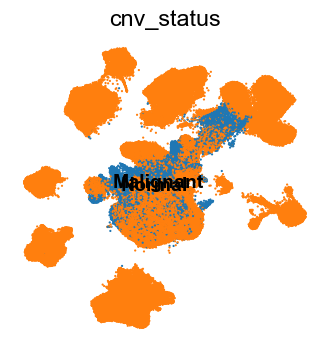

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_concat, color=['cnv_status'], show=False, ax=ax, size=10, palette=sc.pl.palettes.vega_20_scanpy, legend_loc='on data')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(  handletextpad=0.5, frameon=False,
#                     borderpad=0.6,
#                     columnspacing=1.3,
#                     handlelength=0.65, fontsize=12)
fig.savefig(f'{figPath}/EBV-major_cnv_status.png', dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


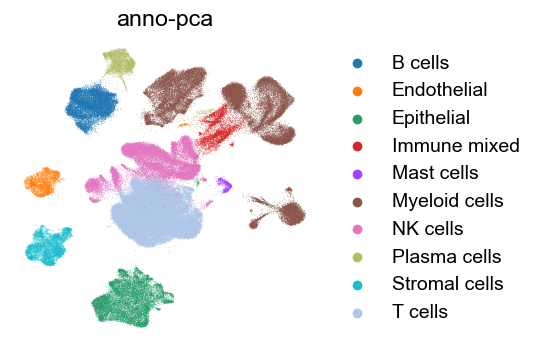

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_concat, color=['anno-pca'], show=False, ax=ax, palette=sc.pl.palettes.vega_20_scanpy)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(f'{figPath}/EBV-major_annotation.png', dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


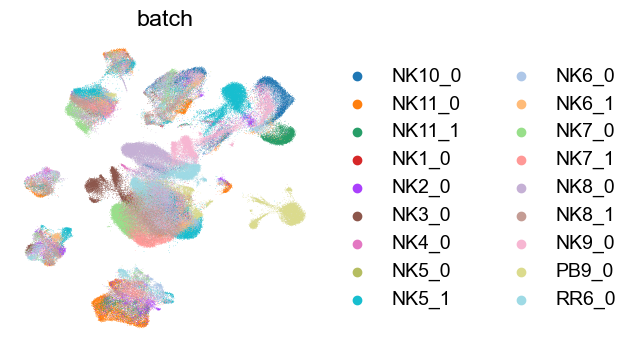

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_concat, color=['batch'], show=False, ax=ax, palette=sc.pl.palettes.vega_20_scanpy)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(f'{figPath}/EBV-major_batch.png', dpi=400, bbox_inches='tight')

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


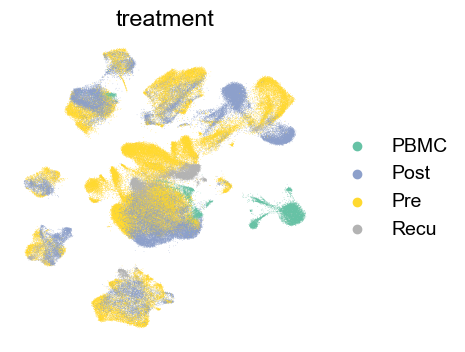

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_concat, color=['treatment'], show=False, ax=ax, palette="Set2")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(f'{figPath}/EBV-major_treatment.png', dpi=400, bbox_inches='tight')

Save adata_concat_cnv and cnv_status results

In [217]:
adata_concat_cnv.write_h5ad('/data/NKTCL/NKTCL_Multi/analysis/NKTCL-cnv-EBV-3.8.h5ad')

In [218]:
adata_concat.var_names_make_unique()
adata_concat.write_h5ad("/data/NKTCL/NKTCL_Multi/analysis/NKTCL-gex-EBV-3.8.h5ad")

Prepare data for cytotrace analysis

In [10]:
from cytotrace2_py.cytotrace2_py import cytotrace2

In [19]:
adata_concat = sc.read_h5ad("/data/NKTCL/NKTCL_Multi/analysis/NKTCL-gex-2.18.h5ad")

In [32]:
annotation = adata_concat.obs['anno-pca']
annotation.columns=['phenotype']
annotation.to_csv('/data/NKTCL/NKTCL_Multi/analysis/NKTCL-cytotrace2-anno-2.19.tsv', sep='\t', index=True, header=True)

In [22]:
data = adata_concat.layers['Raw'].astype('int')

In [23]:
cytodf = pd.DataFrame(data.todense(), index=adata_concat.obs_names, columns=adata_concat.var_names, dtype=int)

In [24]:
cytodf = cytodf.T

In [2]:
import datatable as dt

In [28]:
cytodt = dt.Frame(cytodf)

In [31]:
cytodt.to_csv('/data/NKTCL/NKTCL_Multi/analysis/NKTCL-cytotrace2-2.19.tsv.gz', sep='\t', compression='gzip')

In [33]:
cytores = cytotrace2('/data/NKTCL/NKTCL_Multi/analysis/NKTCL-cytotrace2-2.19.tsv.gz',
                     annotation_path = '/data/NKTCL/NKTCL_Multi/analysis/NKTCL-cytotrace2-anno-2.19.tsv',
                     species='human',
                     batch_size=10000,
                     smooth_batch_size=1000,
                     max_cores=24,
                     seed=14,
                     disable_plotting = False,
                     disable_parallelization=False)